**Tools - Polars**

*The `polars` library is a high-performance DataFrame library written in Rust, designed for speed and efficiency. It uses the Apache Arrow memory format under the hood and provides an expressive, composable API based on expressions. Unlike pandas, Polars does not use row indices - instead, it focuses on column-oriented operations that are optimized for both single-threaded and parallel execution. Polars DataFrames are immutable, meaning operations return new DataFrames rather than modifying in place. The library supports both eager and lazy evaluation, enabling query optimization before execution.*

Prerequisites:
* NumPy - if you are not familiar with NumPy, we recommend that you go through the [NumPy tutorial](tools_numpy.ipynb) now.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-mlp/blob/main/tools_polars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-mlp/blob/main/tools_polars.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import `polars`. People usually import it as `pl`:

In [89]:
import polars as pl

We'll also need NumPy and matplotlib for some examples:

In [90]:
import numpy as np
import matplotlib.pyplot as plt

Let's check the Polars version:

In [91]:
pl.__version__

'1.37.1'

## Key Differences from pandas

Before we dive in, here are the key differences between Polars and pandas that you should keep in mind:

| Aspect | pandas | Polars |
|--------|--------|--------|
| Row indices | Named row indices (labels) | Positional only (no named indices) |
| Mutability | In-place modifications available | Immutable - operations return new DataFrames |
| API style | Method-based on objects | Expression-based (`pl.col()`, `pl.lit()`) |
| String expressions | `eval()`, `query()` | Must use expression API |
| Multi-index | Supported | Not supported (flat structure) |
| Execution | Eager only | Supports both eager and lazy evaluation |
| Preferred file format | CSV common | Parquet preferred |

These differences reflect Polars' focus on performance and explicit, composable operations.

# `Series` objects
The `polars` library contains the following useful data structures:
* `Series` objects. A `Series` object is a 1D array, similar to a column in a spreadsheet. Unlike pandas, Polars Series do not have named row indices.
* `DataFrame` objects. This is a 2D table, similar to a spreadsheet (with column names but no row labels).

Let's start by exploring Series objects.

## Creating a `Series`
Let's start by creating our first `Series` object!

In [92]:
s = pl.Series([2, -1, 3, 5])
s

""
i64
2
-1
3
5


Notice that Polars inferred the data type as `i64` (64-bit integer). You can also specify the dtype explicitly:

In [93]:
s_float = pl.Series([2, -1, 3, 5], dtype=pl.Float64)
s_float

""
f64
2.0
-1.0
3.0
5.0


## Note on Init from `dict`

In pandas, you can create a Series from a dictionary, where the keys become the row index labels:
```python
# pandas style (NOT Polars)
s = pd.Series({"alice": 68, "bob": 83, "charles": 112})
s["bob"]  # Access by label -> 83
```

**In Polars, this is not possible** because Series do not have named indices. If you need labeled data, use a DataFrame with two columns instead (as shown in the "Using DataFrames for Labeled Data" section below).

## Similar to a 1D `ndarray`
`Series` objects behave much like one-dimensional NumPy `ndarray`s. You can use NumPy functions directly on them, or use Polars' built-in methods:

In [94]:
# Using NumPy functions
np.exp(s)

""
f64
7.389056
0.367879
20.085537
148.413159


In [95]:
# Using Polars' built-in methods (preferred for performance)
s.exp()

""
f64
7.389056
0.367879
20.085537
148.413159


Arithmetic operations on `Series` are also possible, and they apply *elementwise*. Note that unlike pandas, you must use another `Series` (not a Python list) for elementwise operations:

In [96]:
s + pl.Series([1000, 2000, 3000, 4000])

""
i64
1002
1999
3003
4005


Like NumPy, if you add a single number to a `Series`, that number is added to all items in the `Series`. This is called *broadcasting*:

In [97]:
s + 1000

""
i64
1002
999
1003
1005


The same is true for all binary operations such as `*` or `/`, and even conditional operations:

In [98]:
s < 0

""
bool
false
true
false
false


## Positional Access

**Key difference from pandas:** Polars Series use positional (integer) indexing only. There are no named row indices like in pandas. This is a deliberate design choice that improves performance and reduces ambiguity.

You can access elements by their position:

In [99]:
s[0]  # First element

2

In [100]:
s[1]  # Second element

-1

In [101]:
s[-1]  # Last element

5

Slicing also works:

In [102]:
s[1:3]  # Elements at positions 1 and 2

""
i64
-1
3


## Using DataFrames for Labeled Data

In pandas, you might use named indices for labeled data:
```python
# pandas style (NOT Polars)
s = pd.Series([68, 83, 112, 68], index=["alice", "bob", "charles", "darwin"])
s["bob"]  # Access by label
```

In Polars, the idiomatic way to work with labeled data is to use a DataFrame with a name column:

In [103]:
# Polars way: use a DataFrame with a name column
weights = pl.DataFrame({
    "name": ["alice", "bob", "charles", "darwin"],
    "weight": [68, 83, 112, 68]
})
weights

name,weight
str,i64
"""alice""",68
"""bob""",83
"""charles""",112
"""darwin""",68


To access data by label, use the `filter()` method:

In [104]:
# Get Bob's weight
weights.filter(pl.col("name") == "bob")

name,weight
str,i64
"""bob""",83


In [105]:
# Get just the weight value
weights.filter(pl.col("name") == "bob")["weight"][0]

83

You can also access by position using row indexing:

In [106]:
# Access second row (index 1)
weights[1]

name,weight
str,i64
"""bob""",83


## Note on Automatic Alignment

In pandas, when you perform operations on two Series with different indices, pandas automatically aligns them by their index labels. **Polars does not do this** - operations between Series are strictly positional.

This means:
- Series must have the same length for elementwise operations
- There's no concept of "missing" values due to index misalignment
- For joining data by labels, use DataFrame join operations (covered later)

This design choice makes operations more predictable and faster.

## Init with a scalar
You can create a `Series` with repeated values using the `repeat` method or by passing a list:

In [107]:
# Create a Series with repeated values
meaning = pl.Series("meaning", [42] * 3)
meaning

meaning
i64
42
42
42


In [108]:
# Or use pl.repeat in a DataFrame context
pl.DataFrame({"life": [42], "universe": [42], "everything": [42]})

life,universe,everything
i64,i64,i64
42,42,42


## `Series` name
A `Series` can have a `name`. You can set it during creation or use the `alias()` method:

In [109]:
# Set name during creation
s6 = pl.Series("weights", [83, 68])
s6

weights
i64
83
68


In [110]:
# Or rename an existing Series
s.alias("my_series")

my_series
i64
2
-1
3
5


## Plotting a `Series`
Polars has native plotting support via Altair (requires `altair>=5.4.0`), but for matplotlib compatibility, you can convert to pandas or use the values directly:

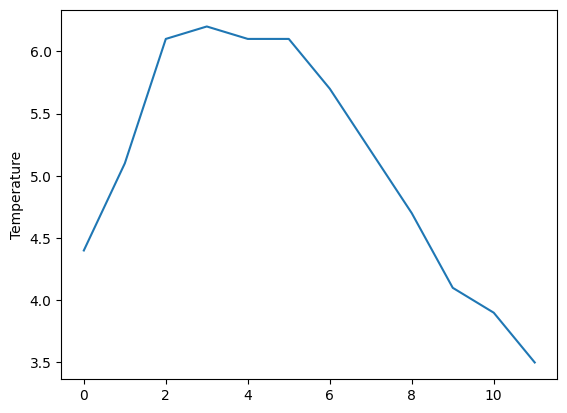

In [111]:
temperatures = pl.Series("Temperature", [4.4, 5.1, 6.1, 6.2, 6.1, 6.1, 5.7, 5.2, 4.7, 4.1, 3.9, 3.5])

# Plot using matplotlib (convert to pandas for convenience)
temperatures.to_pandas().plot()
plt.ylabel("Temperature")
plt.show()

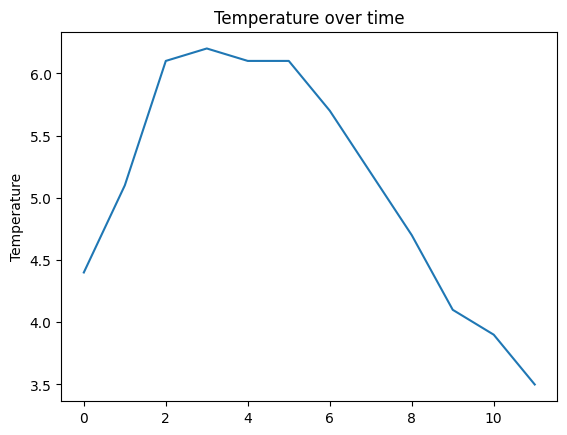

In [112]:
# Or use matplotlib directly with the values
plt.plot(temperatures.to_list())
plt.ylabel("Temperature")
plt.title("Temperature over time")
plt.show()

# Handling time
Many datasets have timestamps, and Polars provides excellent support for temporal data:
* Creating datetime ranges with `pl.datetime_range()`
* Resampling with `group_by_dynamic()`
* Upsampling with `upsample()` and interpolation
* Timezone handling with `dt.replace_time_zone()` and `dt.convert_time_zone()`

**Note:** Unlike pandas, Polars does not have a `PeriodIndex` concept. Dates are represented as actual timestamps.

## Time range
Let's start by creating a time series using `pl.datetime_range()`. Unlike pandas, you specify start and end dates (not number of periods):

In [113]:
from datetime import datetime, timedelta

start = datetime(2016, 10, 29, 17, 30)
end = start + timedelta(hours=11)

dates = pl.datetime_range(start, end, interval="1h", eager=True)
dates

literal
datetime[μs]
2016-10-29 17:30:00
2016-10-29 18:30:00
2016-10-29 19:30:00
2016-10-29 20:30:00
2016-10-29 21:30:00
…
2016-10-30 00:30:00
2016-10-30 01:30:00
2016-10-30 02:30:00


This returns a `Series` of datetimes. In Polars, we use this as a column in a DataFrame (not as an index like in pandas):

In [114]:
temperatures = [4.4, 5.1, 6.1, 6.2, 6.1, 6.1, 5.7, 5.2, 4.7, 4.1, 3.9, 3.5]
temp_df = pl.DataFrame({
    "datetime": dates,
    "temperature": temperatures
})
temp_df

datetime,temperature
datetime[μs],f64
2016-10-29 17:30:00,4.4
2016-10-29 18:30:00,5.1
2016-10-29 19:30:00,6.1
2016-10-29 20:30:00,6.2
2016-10-29 21:30:00,6.1
…,…
2016-10-30 00:30:00,5.2
2016-10-30 01:30:00,4.7
2016-10-30 02:30:00,4.1


Let's plot this time series:

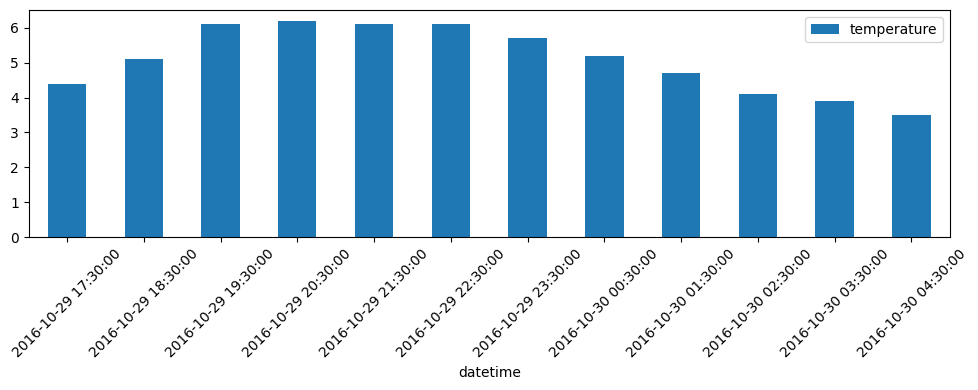

In [115]:
# Convert to pandas for matplotlib plotting
temp_pandas = temp_df.to_pandas()
temp_pandas.plot(x="datetime", y="temperature", kind="bar", figsize=(10, 4))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Resampling
Polars uses `group_by_dynamic()` instead of pandas' `resample()`. This groups data by time windows:

In [116]:
# Resample to 2-hour intervals and compute the mean
temp_resampled = temp_df.group_by_dynamic("datetime", every="2h").agg(
    pl.col("temperature").mean()
)
temp_resampled

datetime,temperature
datetime[μs],f64
2016-10-29 16:00:00,4.4
2016-10-29 18:00:00,5.6
2016-10-29 20:00:00,6.15
2016-10-29 22:00:00,5.9
2016-10-30 00:00:00,4.95
2016-10-30 02:00:00,4.0
2016-10-30 04:00:00,3.5


Notice that the values have been aggregated into 2-hour periods. The 6-8pm period, for example, shows the mean of `5.1` (at 6:30pm) and `6.1` (at 7:30pm), which is `5.6`.

You can use different aggregation functions:

In [117]:
# Use minimum instead of mean
temp_df.group_by_dynamic("datetime", every="2h").agg(
    pl.col("temperature").min()
)

datetime,temperature
datetime[μs],f64
2016-10-29 16:00:00,4.4
2016-10-29 18:00:00,5.1
2016-10-29 20:00:00,6.1
2016-10-29 22:00:00,5.7
2016-10-30 00:00:00,4.7
2016-10-30 02:00:00,3.9
2016-10-30 04:00:00,3.5


In [118]:
# Multiple aggregations at once
temp_df.group_by_dynamic("datetime", every="2h").agg([
    pl.col("temperature").mean().alias("temp_mean"),
    pl.col("temperature").min().alias("temp_min"),
    pl.col("temperature").max().alias("temp_max")
])

datetime,temp_mean,temp_min,temp_max
datetime[μs],f64,f64,f64
2016-10-29 16:00:00,4.4,4.4,4.4
2016-10-29 18:00:00,5.6,5.1,6.1
2016-10-29 20:00:00,6.15,6.1,6.2
2016-10-29 22:00:00,5.9,5.7,6.1
2016-10-30 00:00:00,4.95,4.7,5.2
2016-10-30 02:00:00,4.0,3.9,4.1
2016-10-30 04:00:00,3.5,3.5,3.5


## Upsampling and interpolation
The previous examples showed downsampling (reducing frequency). We can also upsample (increase frequency), which creates null values that can be filled with interpolation:

In [119]:
# Upsample to 15-minute intervals
temp_upsampled = temp_df.upsample("datetime", every="15m")
temp_upsampled.head(10)  # Note the null values

datetime,temperature
datetime[μs],f64
2016-10-29 17:30:00,4.4
2016-10-29 17:45:00,null
2016-10-29 18:00:00,null
2016-10-29 18:15:00,null
2016-10-29 18:30:00,5.1
2016-10-29 18:45:00,null
2016-10-29 19:00:00,null
2016-10-29 19:15:00,null
2016-10-29 19:30:00,6.1


Now let's fill the nulls using linear interpolation:

In [120]:
# Interpolate the null values
temp_interpolated = temp_upsampled.with_columns(
    pl.col("temperature").interpolate()
)
temp_interpolated.head(10)

datetime,temperature
datetime[μs],f64
2016-10-29 17:30:00,4.4
2016-10-29 17:45:00,4.575
2016-10-29 18:00:00,4.75
2016-10-29 18:15:00,4.925
2016-10-29 18:30:00,5.1
2016-10-29 18:45:00,5.35
2016-10-29 19:00:00,5.6
2016-10-29 19:15:00,5.85
2016-10-29 19:30:00,6.1


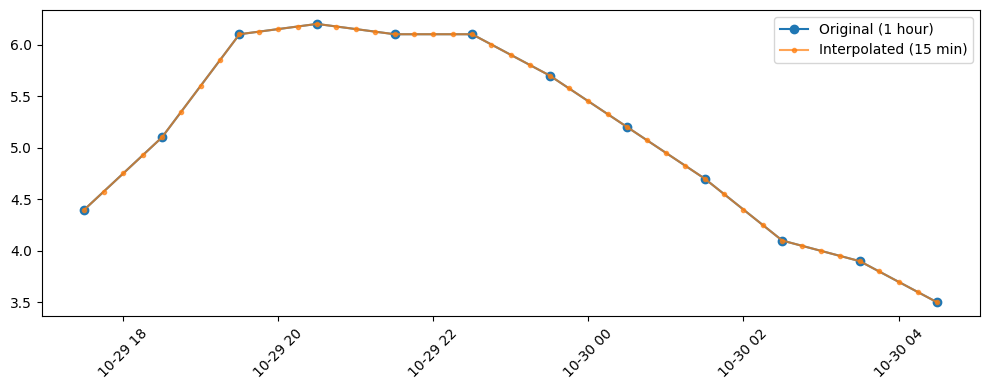

In [121]:
# Plot original vs interpolated
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(temp_df["datetime"].to_list(), temp_df["temperature"].to_list(),
        'o-', label="Original (1 hour)")
ax.plot(temp_interpolated["datetime"].to_list(), temp_interpolated["temperature"].to_list(),
        '.-', alpha=0.7, label="Interpolated (15 min)")
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Timezones
By default, datetimes in Polars are *naive* (not timezone-aware). You can make them timezone-aware using `dt.replace_time_zone()`:

In [122]:
# Add timezone information (this is like tz_localize in pandas)
temp_ny = temp_df.with_columns(
    pl.col("datetime").dt.replace_time_zone("America/New_York")
)
temp_ny

datetime,temperature
"datetime[μs, America/New_York]",f64
2016-10-29 17:30:00 EDT,4.4
2016-10-29 18:30:00 EDT,5.1
2016-10-29 19:30:00 EDT,6.1
2016-10-29 20:30:00 EDT,6.2
2016-10-29 21:30:00 EDT,6.1
…,…
2016-10-30 00:30:00 EDT,5.2
2016-10-30 01:30:00 EDT,4.7
2016-10-30 02:30:00 EDT,4.1


Notice the `EDT` suffix indicating Eastern Daylight Time. We can convert to another timezone using `dt.convert_time_zone()`:

In [123]:
# Convert to Paris time (this is like tz_convert in pandas)
temp_paris = temp_ny.with_columns(
    pl.col("datetime").dt.convert_time_zone("Europe/Paris")
)
temp_paris

datetime,temperature
"datetime[μs, Europe/Paris]",f64
2016-10-29 23:30:00 CEST,4.4
2016-10-30 00:30:00 CEST,5.1
2016-10-30 01:30:00 CEST,6.1
2016-10-30 02:30:00 CEST,6.2
2016-10-30 02:30:00 CET,6.1
…,…
2016-10-30 05:30:00 CET,5.2
2016-10-30 06:30:00 CET,4.7
2016-10-30 07:30:00 CET,4.1


Notice that the times have been adjusted for the Paris timezone. You may also notice the `CEST` to `CET` transition as France switches to winter time during this period.

To remove timezone information and get naive datetimes again:

In [124]:
# Remove timezone info
temp_naive = temp_paris.with_columns(
    pl.col("datetime").dt.replace_time_zone(None)
)
temp_naive

datetime,temperature
datetime[μs],f64
2016-10-29 23:30:00,4.4
2016-10-30 00:30:00,5.1
2016-10-30 01:30:00,6.1
2016-10-30 02:30:00,6.2
2016-10-30 02:30:00,6.1
…,…
2016-10-30 05:30:00,5.2
2016-10-30 06:30:00,4.7
2016-10-30 07:30:00,4.1


## Date components
Polars provides many methods to extract components from datetime columns:

In [125]:
temp_df.with_columns([
    pl.col("datetime").dt.year().alias("year"),
    pl.col("datetime").dt.month().alias("month"),
    pl.col("datetime").dt.day().alias("day"),
    pl.col("datetime").dt.hour().alias("hour"),
    pl.col("datetime").dt.minute().alias("minute")
])

datetime,temperature,year,month,day,hour,minute
datetime[μs],f64,i32,i8,i8,i8,i8
2016-10-29 17:30:00,4.4,2016,10,29,17,30
2016-10-29 18:30:00,5.1,2016,10,29,18,30
2016-10-29 19:30:00,6.1,2016,10,29,19,30
2016-10-29 20:30:00,6.2,2016,10,29,20,30
2016-10-29 21:30:00,6.1,2016,10,29,21,30
…,…,…,…,…,…,…
2016-10-30 00:30:00,5.2,2016,10,30,0,30
2016-10-30 01:30:00,4.7,2016,10,30,1,30
2016-10-30 02:30:00,4.1,2016,10,30,2,30


## Note on Periods
Unlike pandas, Polars does not have a `Period` or `PeriodIndex` type. If you need to work with fiscal quarters or other period-based data, you can:
1. Use date truncation: `dt.truncate("1q")` to truncate to quarters
2. Extract quarter information: `dt.quarter()`
3. Create custom period labels using string formatting

In [126]:
# Example: create quarterly labels
quarterly_data = pl.DataFrame({
    "date": pl.date_range(datetime(2016, 1, 1), datetime(2017, 12, 31), "1mo", eager=True),
    "revenue": [300, 310, 320, 290, 390, 380, 320, 340, 360, 310, 370, 410,
                320, 330, 340, 300, 400, 390, 330, 350, 370, 320, 380, 420]
})

# Add quarter information
quarterly_data = quarterly_data.with_columns([
    pl.col("date").dt.year().alias("year"),
    pl.col("date").dt.quarter().alias("quarter")
])

# Group by year and quarter
quarterly_data.group_by(["year", "quarter"]).agg(
    pl.col("revenue").sum()
).sort(["year", "quarter"])

year,quarter,revenue
i32,i8,i64
2016,1,930
2016,2,1060
2016,3,1020
2016,4,1090
2017,1,990
2017,2,1090
2017,3,1050
2017,4,1120


# `DataFrame` objects
A DataFrame object represents a 2D table with cell values and column names. Unlike pandas, Polars DataFrames do not have row index labels - rows are accessed by position. You can think of `DataFrame`s as dictionaries of `Series`.

## Creating a `DataFrame`
You can create a DataFrame by passing a dictionary of lists or Series:

In [127]:
people = pl.DataFrame({
    "name": ["alice", "bob", "charles"],
    "weight": [68, 83, 112],
    "birthyear": [1985, 1984, 1992],
    "children": [None, 3, 0],
    "hobby": ["Biking", "Dancing", None]
})
people

name,weight,birthyear,children,hobby
str,i64,i64,i64,str
"""alice""",68,1985,null,"""Biking"""
"""bob""",83,1984,3,"""Dancing"""
"""charles""",112,1992,0,null


A few things to note:
* Missing values are represented as `null`
* Polars automatically infers data types
* There are no row index labels - just row positions (0, 1, 2, ...)

You can also create a DataFrame from a list of dictionaries:

In [128]:
pl.DataFrame([
    {"name": "alice", "weight": 68, "birthyear": 1985},
    {"name": "bob", "weight": 83, "birthyear": 1984},
    {"name": "charles", "weight": 112, "birthyear": 1992}
])

name,weight,birthyear
str,i64,i64
"""alice""",68,1985
"""bob""",83,1984
"""charles""",112,1992


Or from a NumPy array:

In [129]:
values = np.array([
    [1985, 68],
    [1984, 83],
    [1992, 112]
])
pl.DataFrame(values, schema=["birthyear", "weight"], orient="row")

birthyear,weight
i64,i64
1985,68
1984,83
1992,112


## Accessing columns
You can access a single column using bracket notation, which returns a `Series`:

In [130]:
people["birthyear"]

birthyear
i64
1985
1984
1992


For a DataFrame result, use `select()`:

In [131]:
people.select("birthyear")

birthyear
i64
1985
1984
1992


You can select multiple columns by passing a list:

In [132]:
people.select(["birthyear", "hobby"])

birthyear,hobby
i64,str
1985,"""Biking"""
1984,"""Dancing"""
1992,null


## Accessing rows
Use integer indexing to access rows:

In [133]:
# Get first row (returns a DataFrame)
people[0]

name,weight,birthyear,children,hobby
str,i64,i64,i64,str
"""alice""",68,1985,null,"""Biking"""


In [134]:
# Get rows 1 and 2
people[1:3]

name,weight,birthyear,children,hobby
str,i64,i64,i64,str
"""bob""",83,1984,3,"""Dancing"""
"""charles""",112,1992,0,null


In [135]:
# Get a single row as a tuple
people.row(2)

('charles', 112, 1992, 0, None)

In [136]:
# Get a single row as a dictionary
people.row(2, named=True)

{'name': 'charles',
 'weight': 112,
 'birthyear': 1992,
 'children': 0,
 'hobby': None}

## Note on Multi-indexing

Unlike pandas, Polars does not support hierarchical (multi-level) row or column indices. This is a deliberate design choice:
* It simplifies the API and mental model
* It improves performance
* Hierarchical data can be represented using multiple columns

If you need hierarchical structure, use multiple columns and `group_by()` or `pivot()` operations.

## Transposing
You can swap rows and columns using the `transpose()` method:

In [137]:
# Select numeric columns for transpose
people.select(["weight", "birthyear", "children"]).transpose(include_header=True, header_name="person")

person,column_0,column_1,column_2
str,i64,i64,i64
"""weight""",68,83,112
"""birthyear""",1985,1984,1992
"""children""",null,3,0


## Adding and removing columns

**Key difference from pandas:** Polars DataFrames are immutable. All operations return a new DataFrame rather than modifying in place.

Use `with_columns()` to add new columns:

In [138]:
# Add a new column computed from existing columns
people_with_age = people.with_columns(
    (2024 - pl.col("birthyear")).alias("age")
)
people_with_age

name,weight,birthyear,children,hobby,age
str,i64,i64,i64,str,i64
"""alice""",68,1985,null,"""Biking""",39
"""bob""",83,1984,3,"""Dancing""",40
"""charles""",112,1992,0,null,32


In [139]:
# Add multiple columns at once
people_extended = people_with_age.with_columns([
    (pl.col("age") > 30).alias("over_30"),
    (pl.col("weight") / 1.75**2).round(2).alias("bmi")
])
people_extended

name,weight,birthyear,children,hobby,age,over_30,bmi
str,i64,i64,i64,str,i64,bool,f64
"""alice""",68,1985,null,"""Biking""",39,true,22.2
"""bob""",83,1984,3,"""Dancing""",40,true,27.1
"""charles""",112,1992,0,null,32,true,36.57


Use `drop()` to remove columns:

In [140]:
people_extended.drop(["birthyear", "children"])

name,weight,hobby,age,over_30,bmi
str,i64,str,i64,bool,f64
"""alice""",68,"""Biking""",39,true,22.2
"""bob""",83,"""Dancing""",40,true,27.1
"""charles""",112,null,32,true,36.57


## The Expression API

Polars uses an expression-based API that's different from pandas. The key building blocks are:

* `pl.col("column_name")` - reference a column
* `pl.lit(value)` - create a literal value
* `pl.when(condition).then(value).otherwise(value)` - conditional expressions

This replaces pandas' `eval()` and string-based expressions:

In [141]:
# pandas equivalent: df.eval("weight / (height/100) ** 2 > 25")
# In Polars, we use expressions:
people_extended.select(
    (pl.col("weight") / 1.75**2 > 25).alias("overweight_check")
)

overweight_check
bool
false
true
true


In [142]:
# Conditional expressions with when/then/otherwise
people.with_columns(
    pl.when(pl.col("weight") < 75)
      .then(pl.lit("light"))
      .when(pl.col("weight") < 100)
      .then(pl.lit("medium"))
      .otherwise(pl.lit("heavy"))
      .alias("weight_category")
)

name,weight,birthyear,children,hobby,weight_category
str,i64,i64,i64,str,str
"""alice""",68,1985,null,"""Biking""","""light"""
"""bob""",83,1984,3,"""Dancing""","""medium"""
"""charles""",112,1992,0,null,"""heavy"""


## Filtering (Querying)

Instead of pandas' `query()` method with string expressions, Polars uses `filter()` with expressions:

In [143]:
# pandas equivalent: df.query("birthyear < 1990")
people.filter(pl.col("birthyear") < 1990)

name,weight,birthyear,children,hobby
str,i64,i64,i64,str
"""alice""",68,1985,null,"""Biking"""
"""bob""",83,1984,3,"""Dancing"""


In [144]:
# Multiple conditions (use & for AND, | for OR)
# pandas equivalent: df.query("birthyear < 1990 and weight > 70")
people.filter(
    (pl.col("birthyear") < 1990) & (pl.col("weight") > 70)
)

name,weight,birthyear,children,hobby
str,i64,i64,i64,str
"""bob""",83,1984,3,"""Dancing"""


In [145]:
# Filter with null handling
people.filter(pl.col("hobby").is_not_null())

name,weight,birthyear,children,hobby
str,i64,i64,i64,str
"""alice""",68,1985,null,"""Biking"""
"""bob""",83,1984,3,"""Dancing"""


## Sorting

Use `sort()` to sort a DataFrame:

In [146]:
people.sort("weight")

name,weight,birthyear,children,hobby
str,i64,i64,i64,str
"""alice""",68,1985,null,"""Biking"""
"""bob""",83,1984,3,"""Dancing"""
"""charles""",112,1992,0,null


In [147]:
# Sort descending
people.sort("weight", descending=True)

name,weight,birthyear,children,hobby
str,i64,i64,i64,str
"""charles""",112,1992,0,null
"""bob""",83,1984,3,"""Dancing"""
"""alice""",68,1985,null,"""Biking"""


In [148]:
# Sort by multiple columns
people.sort(["hobby", "weight"], descending=[False, True], nulls_last=True)

name,weight,birthyear,children,hobby
str,i64,i64,i64,str
"""alice""",68,1985,null,"""Biking"""
"""bob""",83,1984,3,"""Dancing"""
"""charles""",112,1992,0,null


## Chaining operations

One of Polars' strengths is method chaining. You can combine multiple operations in a fluent, readable way:

In [149]:
(
    people
    .with_columns((2024 - pl.col("birthyear")).alias("age"))
    .with_columns((pl.col("weight") / 1.75**2).round(2).alias("bmi"))
    .filter(pl.col("age") > 30)
    .sort("bmi", descending=True)
    .select(["name", "age", "bmi"])
)

name,age,bmi
str,i64,f64
"""charles""",32,36.57
"""bob""",40,27.1
"""alice""",39,22.2


## Plotting a `DataFrame`

For plotting, convert to pandas and use matplotlib:

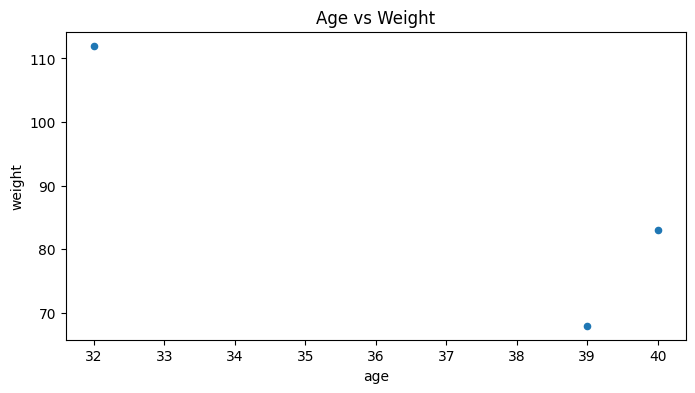

In [150]:
# Create a sample DataFrame for plotting
plot_data = people.with_columns([
    (2024 - pl.col("birthyear")).alias("age"),
    pl.col("weight").cast(pl.Float64)
]).select(["name", "age", "weight"])

# Convert to pandas and plot
plot_data.to_pandas().plot(x="age", y="weight", kind="scatter", figsize=(8, 4))
plt.title("Age vs Weight")
plt.show()

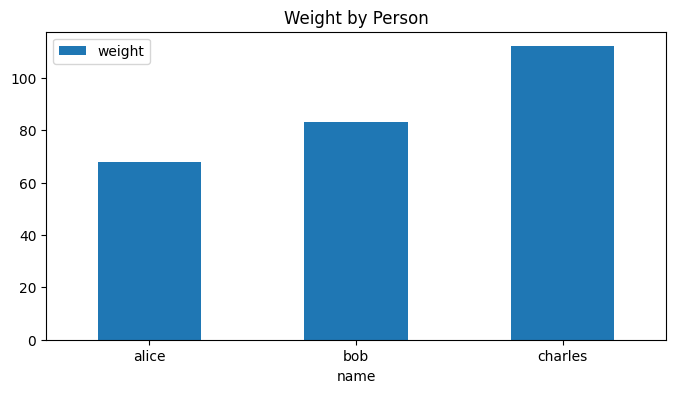

In [151]:
# Bar plot
plot_data.to_pandas().plot(x="name", y="weight", kind="bar", figsize=(8, 4))
plt.title("Weight by Person")
plt.xticks(rotation=0)
plt.show()

## Operations on `DataFrame`s

Polars supports many mathematical and aggregation operations. Let's create a DataFrame to demonstrate:

In [152]:
grades = pl.DataFrame({
    "name": ["alice", "bob", "charles", "darwin"],
    "sep": [8, 10, 4, 9],
    "oct": [8, 9, 8, 10],
    "nov": [9, 9, 2, 10]
})
grades

name,sep,oct,nov
str,i64,i64,i64
"""alice""",8,8,9
"""bob""",10,9,9
"""charles""",4,8,2
"""darwin""",9,10,10


You can apply mathematical functions to all numeric columns:

In [153]:
# Square root of all numeric columns
grades.select(["name"] + [pl.col(c).sqrt() for c in ["sep", "oct", "nov"]])

name,sep,oct,nov
str,f64,f64,f64
"""alice""",2.828427,2.828427,3.0
"""bob""",3.162278,3.0,3.0
"""charles""",2.0,2.828427,1.414214
"""darwin""",3.0,3.162278,3.162278


Adding a scalar to all numeric values (*broadcasting*):

In [154]:
grades.select(["name"] + [pl.col(c) + 1 for c in ["sep", "oct", "nov"]])

name,sep,oct,nov
str,i64,i64,i64
"""alice""",9,9,10
"""bob""",11,10,10
"""charles""",5,9,3
"""darwin""",10,11,11


Comparison operations:

In [155]:
grades.select(["name"] + [(pl.col(c) >= 5).alias(c) for c in ["sep", "oct", "nov"]])

name,sep,oct,nov
str,bool,bool,bool
"""alice""",true,true,true
"""bob""",true,true,true
"""charles""",false,true,false
"""darwin""",true,true,true


### Aggregations

Aggregation operations like `mean()`, `sum()`, `max()`, `min()` compute a single value per column:

In [156]:
# Mean of each numeric column
grades.select([pl.col(c).mean() for c in ["sep", "oct", "nov"]])

sep,oct,nov
f64,f64,f64
7.75,8.75,7.5


In [157]:
# Multiple aggregations
grades.select([
    pl.col("sep").mean().alias("sep_mean"),
    pl.col("sep").max().alias("sep_max"),
    pl.col("sep").min().alias("sep_min"),
    pl.col("sep").std().alias("sep_std")
])

sep_mean,sep_max,sep_min,sep_std
f64,i64,i64,f64
7.75,10,4,2.629956


### Boolean aggregations

The `all()` method checks if all values in a column satisfy a condition:

In [158]:
# Check which months all students scored > 5
grades.select([(pl.col(c) > 5).all().alias(c) for c in ["sep", "oct", "nov"]])

sep,oct,nov
bool,bool,bool
false,true,false


The `any()` method checks if any value satisfies a condition:

In [159]:
# Check which months any student scored 10
grades.select([(pl.col(c) == 10).any().alias(c) for c in ["sep", "oct", "nov"]])

sep,oct,nov
bool,bool,bool
true,true,true


### Horizontal operations

Polars provides functions to operate across rows (horizontally):

In [160]:
# Sum across all grade columns for each student
grades.with_columns(
    pl.sum_horizontal(["sep", "oct", "nov"]).alias("total")
)

name,sep,oct,nov,total
str,i64,i64,i64,i64
"""alice""",8,8,9,25
"""bob""",10,9,9,28
"""charles""",4,8,2,14
"""darwin""",9,10,10,29


In [161]:
# Mean across all grade columns for each student
grades.with_columns(
    pl.mean_horizontal(["sep", "oct", "nov"]).alias("average")
)

name,sep,oct,nov,average
str,i64,i64,i64,f64
"""alice""",8,8,9,8.333333
"""bob""",10,9,9,9.333333
"""charles""",4,8,2,4.666667
"""darwin""",9,10,10,9.666667


In [162]:
# Check if all grades > 5 for each student
grades.with_columns(
    pl.all_horizontal([(pl.col(c) > 5) for c in ["sep", "oct", "nov"]]).alias("all_passing")
)

name,sep,oct,nov,all_passing
str,i64,i64,i64,bool
"""alice""",8,8,9,true
"""bob""",10,9,9,true
"""charles""",4,8,2,false
"""darwin""",9,10,10,true


# Handling missing data

Dealing with missing data is a frequent task when working with real-life data. Polars uses `null` to represent missing values and provides several methods to handle them.

Let's create a DataFrame with some missing values:

In [163]:
data_with_nulls = pl.DataFrame({
    "name": ["alice", "bob", "charles", "darwin"],
    "sep": [8.0, 10.0, None, 9.0],
    "oct": [8.0, None, 8.0, 10.0],
    "nov": [9.0, 9.0, 2.0, None]
})
data_with_nulls

name,sep,oct,nov
str,f64,f64,f64
"""alice""",8.0,8.0,9.0
"""bob""",10.0,null,9.0
"""charles""",null,8.0,2.0
"""darwin""",9.0,10.0,null


## Filling null values

Use `fill_null()` to replace null values:

In [164]:
# Fill nulls with a specific value
data_with_nulls.fill_null(0)

name,sep,oct,nov
str,f64,f64,f64
"""alice""",8.0,8.0,9.0
"""bob""",10.0,0.0,9.0
"""charles""",0.0,8.0,2.0
"""darwin""",9.0,10.0,0.0


In [165]:
# Fill with different strategies
data_with_nulls.with_columns([
    pl.col("sep").fill_null(strategy="forward").alias("sep_forward"),
    pl.col("oct").fill_null(strategy="mean").alias("oct_mean"),
    pl.col("nov").fill_null(pl.col("nov").mean()).alias("nov_mean")
])

name,sep,oct,nov,sep_forward,oct_mean,nov_mean
str,f64,f64,f64,f64,f64,f64
"""alice""",8.0,8.0,9.0,8.0,8.0,9.0
"""bob""",10.0,null,9.0,10.0,8.666667,9.0
"""charles""",null,8.0,2.0,10.0,8.0,2.0
"""darwin""",9.0,10.0,null,9.0,10.0,6.666667


## Dropping null values

Use `drop_nulls()` to remove rows with null values:

In [166]:
# Drop rows that have any null value
data_with_nulls.drop_nulls()

name,sep,oct,nov
str,f64,f64,f64
"""alice""",8.0,8.0,9.0


In [167]:
# Drop rows with nulls only in specific columns
data_with_nulls.drop_nulls(subset=["sep", "oct"])

name,sep,oct,nov
str,f64,f64,f64
"""alice""",8.0,8.0,9.0
"""darwin""",9.0,10.0,null


## Interpolation

Use `interpolate()` to fill nulls with interpolated values:

In [168]:
# Interpolate within columns
data_with_nulls.with_columns(
    pl.col(["sep", "oct", "nov"]).interpolate()
)

name,sep,oct,nov
str,f64,f64,f64
"""alice""",8.0,8.0,9.0
"""bob""",10.0,8.0,9.0
"""charles""",9.5,8.0,2.0
"""darwin""",9.0,10.0,null


## Checking for nulls

In [169]:
# Count nulls in each column
data_with_nulls.null_count()

name,sep,oct,nov
u32,u32,u32,u32
0,1,1,1


In [170]:
# Check which values are null
data_with_nulls.select(["name"] + [pl.col(c).is_null().alias(c) for c in ["sep", "oct", "nov"]])

name,sep,oct,nov
str,bool,bool,bool
"""alice""",false,false,false
"""bob""",false,true,false
"""charles""",true,false,false
"""darwin""",false,false,true


# Aggregating with `group_by`

Similar to SQL, Polars allows grouping data and running calculations over each group. Let's add a hobby column to demonstrate:

In [171]:
grades_with_hobby = grades.with_columns(
    pl.Series("hobby", ["Biking", "Dancing", None, "Dancing"])
)
grades_with_hobby

name,sep,oct,nov,hobby
str,i64,i64,i64,str
"""alice""",8,8,9,"""Biking"""
"""bob""",10,9,9,"""Dancing"""
"""charles""",4,8,2,null
"""darwin""",9,10,10,"""Dancing"""


Now let's group by hobby and compute statistics:

In [172]:
grades_with_hobby.group_by("hobby").agg([
    pl.col("sep").mean().alias("sep_mean"),
    pl.col("oct").mean().alias("oct_mean"),
    pl.col("nov").mean().alias("nov_mean")
])

hobby,sep_mean,oct_mean,nov_mean
str,f64,f64,f64
null,4.0,8.0,2.0
"""Dancing""",9.5,9.5,9.5
"""Biking""",8.0,8.0,9.0


Note that the `null` hobby is treated as its own group. The `NaN` values have been skipped when computing means.

You can perform multiple aggregations:

In [173]:
grades_with_hobby.group_by("hobby").agg([
    pl.col("sep").mean().alias("sep_avg"),
    pl.col("sep").count().alias("count"),
    pl.col("name").first().alias("first_name")
])

hobby,sep_avg,count,first_name
str,f64,u32,str
null,4.0,1,"""charles"""
"""Dancing""",9.5,2,"""bob"""
"""Biking""",8.0,1,"""alice"""


# Pivot tables

Polars supports reshaping data with `pivot()` and `unpivot()` (formerly `melt`).

First, let's create a long-format DataFrame:

In [174]:
# Create long format data
long_grades = grades.unpivot(
    index="name",
    on=["sep", "oct", "nov"],
    variable_name="month",
    value_name="grade"
)
long_grades

name,month,grade
str,str,i64
"""alice""","""sep""",8
"""bob""","""sep""",10
"""charles""","""sep""",4
"""darwin""","""sep""",9
"""alice""","""oct""",8
…,…,…
"""darwin""","""oct""",10
"""alice""","""nov""",9
"""bob""","""nov""",9


Now let's pivot it back to wide format:

In [175]:
long_grades.pivot(
    on="month",
    index="name",
    values="grade"
)

name,sep,oct,nov
str,i64,i64,i64
"""alice""",8,8,9
"""bob""",10,9,9
"""charles""",4,8,2
"""darwin""",9,10,10


Pivot with aggregation (useful when there are duplicate combinations):

In [176]:
# Add bonus points and create example with duplicates
# Note: We cast grade to Float64 in both DataFrames since grade * 0.1 produces Float64
long_grades_with_bonus = pl.concat([
    long_grades.with_columns([
        pl.col("grade").cast(pl.Float64),
        pl.lit("grade").alias("type")
    ]),
    long_grades.with_columns([
        (pl.col("grade") * 0.1).alias("grade"),
        pl.lit("bonus").alias("type")
    ])
])

# Pivot with sum aggregation
long_grades_with_bonus.pivot(
    on="month",
    index="name",
    values="grade",
    aggregate_function="sum"
)

name,sep,oct,nov
str,f64,f64,f64
"""alice""",8.8,8.8,9.9
"""bob""",11.0,9.9,9.9
"""charles""",4.4,8.8,2.2
"""darwin""",9.9,11.0,11.0


# Overview functions

When dealing with large DataFrames, it's useful to get a quick overview. Let's create a larger DataFrame to demonstrate:

In [177]:
# Create a larger DataFrame
np.random.seed(42)
large_df = pl.DataFrame({
    "A": np.random.randn(10000),
    "B": np.random.randn(10000),
    "C": np.random.randn(10000),
    "D": np.random.choice(np.array(["cat", "dog", "bird", None], dtype=object), 10000),
    "E": np.random.randint(0, 100, 10000)
})

# Set some values to null
large_df = large_df.with_columns(
    pl.when(pl.col("A") > 2).then(None).otherwise(pl.col("A")).alias("A")
)
large_df

A,B,C,D,E
f64,f64,f64,object,i64
0.496714,-0.678495,0.348286,null,75
-0.138264,-0.305499,0.283324,dog,71
0.647689,-0.597381,-0.93652,null,1
1.52303,0.110418,0.579584,null,48
-0.234153,1.197179,-1.490083,bird,47
…,…,…,…,…
1.301102,0.387827,-0.577288,dog,60
-1.998345,1.377367,1.444604,null,39
-0.705317,0.378354,-0.501367,cat,53


The `head()` method returns the top rows:

In [178]:
large_df.head()

A,B,C,D,E
f64,f64,f64,object,i64
0.496714,-0.678495,0.348286,null,75
-0.138264,-0.305499,0.283324,dog,71
0.647689,-0.597381,-0.93652,null,1
1.52303,0.110418,0.579584,null,48
-0.234153,1.197179,-1.490083,bird,47


In [179]:
large_df.head(3)

A,B,C,D,E
f64,f64,f64,object,i64
0.496714,-0.678495,0.348286,null,75
-0.138264,-0.305499,0.283324,dog,71
0.647689,-0.597381,-0.93652,null,1


The `tail()` method returns the bottom rows:

In [180]:
large_df.tail(2)

A,B,C,D,E
f64,f64,f64,object,i64
0.495766,1.71353,-1.892357,bird,65
0.644388,-1.61992,-0.228884,cat,59


The `describe()` method provides summary statistics:

In [181]:
large_df.describe()

statistic,A,B,C,D,E
str,f64,f64,f64,str,f64
"""count""",9763.0,10000.0,10000.0,"""7554""",10000.0
"""null_count""",237.0,0.0,0.0,"""2446""",0.0
"""mean""",-0.059759,0.013534,-0.012463,null,49.3379
"""std""",0.942502,1.00101,0.991418,null,28.947406
"""min""",-3.9224,-3.856375,-3.655087,null,0.0
"""25%""",-0.695149,-0.661935,-0.70002,null,24.0
"""50%""",-0.032281,0.015909,-0.005744,null,49.0
"""75%""",0.614945,0.693825,0.663893,null,74.0
"""max""",1.995667,4.479084,3.691625,null,99.0


Check the schema (column names and types):

In [182]:
large_df.schema

Schema([('A', Float64),
        ('B', Float64),
        ('C', Float64),
        ('D', Object),
        ('E', Int64)])

In [183]:
large_df.dtypes

[Float64, Float64, Float64, Object, Int64]

In [184]:
large_df.columns

['A', 'B', 'C', 'D', 'E']

In [185]:
large_df.shape

(10000, 5)

The `glimpse()` method provides a compact vertical view:

In [186]:
large_df.glimpse()

Rows: 10000
Columns: 5
$ A    <f64> 0.4967141530112327, -0.13826430117118466, 0.6476885381006925, 1.5230298564080254, -0.23415337472333597, -0.23413695694918055, 1.5792128155073915, 0.7674347291529088, -0.4694743859349521, 0.5425600435859647
$ B    <f64> -0.6784947304872218, -0.3054994630536529, -0.5973810610451429, 0.11041804694611956, 1.1971785314619128, -0.7710421571412046, 1.000820497768414, -0.7816720723468876, -0.8476272124968842, 0.8185946183432132
$ C    <f64> 0.3482862476668184, 0.28332359253566647, -0.9365198458054912, 0.5795842217637382, -1.490082675576618, -0.6541843257603286, -1.9990878128978078, 1.5586265169628146, -0.23154949394529548, 2.1668840348163116
$ D <object> null, dog, null, null, bird, null, null, bird, null, null
$ E    <i64> 75, 71, 1, 48, 47, 54, 79, 66, 30, 25



# Saving & loading

Polars supports various file formats for saving and loading data. **Parquet is the recommended format** for Polars due to its efficiency and native support.

Let's create a sample DataFrame:

In [187]:
my_df = pl.DataFrame({
    "name": ["alice", "bob"],
    "hobby": ["Biking", "Dancing"],
    "weight": [68.5, 83.1],
    "birthyear": [1985, 1984],
    "children": [None, 3]
})
my_df

name,hobby,weight,birthyear,children
str,str,f64,i64,i64
"""alice""","""Biking""",68.5,1985,null
"""bob""","""Dancing""",83.1,1984,3


## Saving to files

In [188]:
# Save to different formats
my_df.write_csv("my_df.csv")
my_df.write_json("my_df.json")
my_df.write_parquet("my_df.parquet")  # Recommended!

Let's look at what was saved:

In [189]:
from pathlib import Path

print("# CSV file:")
print(Path("my_df.csv").read_text())

print("\n# JSON file:")
print(Path("my_df.json").read_text())

# CSV file:
name,hobby,weight,birthyear,children
alice,Biking,68.5,1985,
bob,Dancing,83.1,1984,3


# JSON file:
[{"name":"alice","hobby":"Biking","weight":68.5,"birthyear":1985,"children":null},{"name":"bob","hobby":"Dancing","weight":83.1,"birthyear":1984,"children":3}]


## Loading from files

In [190]:
# Load from CSV
df_from_csv = pl.read_csv("my_df.csv")
df_from_csv

name,hobby,weight,birthyear,children
str,str,f64,i64,i64
"""alice""","""Biking""",68.5,1985,null
"""bob""","""Dancing""",83.1,1984,3


In [191]:
# Load from Parquet (recommended)
df_from_parquet = pl.read_parquet("my_df.parquet")
df_from_parquet

name,hobby,weight,birthyear,children
str,str,f64,i64,i64
"""alice""","""Biking""",68.5,1985,null
"""bob""","""Dancing""",83.1,1984,3


## Reading from URLs

Polars can read directly from URLs:

In [192]:
# Read from a URL
try:
    url = "https://raw.githubusercontent.com/plotly/datasets/master/us-cities-top-1k.csv"
    us_cities = pl.read_csv(url)
    print(us_cities.head())
except Exception as e:
    print(f"Could not load from URL: {e}")

shape: (5, 5)
┌────────────┬────────────────┬────────────┬───────────┬─────────────┐
│ City       ┆ State          ┆ Population ┆ lat       ┆ lon         │
│ ---        ┆ ---            ┆ ---        ┆ ---       ┆ ---         │
│ str        ┆ str            ┆ i64        ┆ f64       ┆ f64         │
╞════════════╪════════════════╪════════════╪═══════════╪═════════════╡
│ Marysville ┆ Washington     ┆ 63269      ┆ 48.051764 ┆ -122.177082 │
│ Perris     ┆ California     ┆ 72326      ┆ 33.782519 ┆ -117.228648 │
│ Cleveland  ┆ Ohio           ┆ 390113     ┆ 41.49932  ┆ -81.694361  │
│ Worcester  ┆ Massachusetts  ┆ 182544     ┆ 42.262593 ┆ -71.802293  │
│ Columbia   ┆ South Carolina ┆ 133358     ┆ 34.00071  ┆ -81.034814  │
└────────────┴────────────────┴────────────┴───────────┴─────────────┘


## Clean up temporary files

In [193]:
import os
for f in ["my_df.csv", "my_df.json", "my_df.parquet"]:
    if os.path.exists(f):
        os.remove(f)

# Combining DataFrames

## SQL-like joins

Polars supports various types of joins. Let's create two DataFrames to demonstrate:

In [194]:
city_loc = pl.DataFrame({
    "state": ["CA", "NY", "FL", "OH", "UT"],
    "city": ["San Francisco", "New York", "Miami", "Cleveland", "Salt Lake City"],
    "lat": [37.781334, 40.705649, 25.791100, 41.473508, 40.755851],
    "lng": [-122.416728, -74.008344, -80.320733, -81.739791, -111.896657]
})
city_loc

state,city,lat,lng
str,str,f64,f64
"""CA""","""San Francisco""",37.781334,-122.416728
"""NY""","""New York""",40.705649,-74.008344
"""FL""","""Miami""",25.7911,-80.320733
"""OH""","""Cleveland""",41.473508,-81.739791
"""UT""","""Salt Lake City""",40.755851,-111.896657


In [195]:
city_pop = pl.DataFrame({
    "city": ["San Francisco", "New York", "Miami", "Houston"],
    "population": [808976, 8363710, 413201, 2242193],
    "state_name": ["California", "New-York", "Florida", "Texas"]
})
city_pop

city,population,state_name
str,i64,str
"""San Francisco""",808976,"""California"""
"""New York""",8363710,"""New-York"""
"""Miami""",413201,"""Florida"""
"""Houston""",2242193,"""Texas"""


### Inner join (default)

In [196]:
city_loc.join(city_pop, on="city", how="inner")

state,city,lat,lng,population,state_name
str,str,f64,f64,i64,str
"""CA""","""San Francisco""",37.781334,-122.416728,808976,"""California"""
"""NY""","""New York""",40.705649,-74.008344,8363710,"""New-York"""
"""FL""","""Miami""",25.7911,-80.320733,413201,"""Florida"""


### Full outer join

In [197]:
city_loc.join(city_pop, on="city", how="full")

state,city,lat,lng,city_right,population,state_name
str,str,f64,f64,str,i64,str
"""CA""","""San Francisco""",37.781334,-122.416728,"""San Francisco""",808976,"""California"""
"""NY""","""New York""",40.705649,-74.008344,"""New York""",8363710,"""New-York"""
"""FL""","""Miami""",25.7911,-80.320733,"""Miami""",413201,"""Florida"""
"""OH""","""Cleveland""",41.473508,-81.739791,null,null,null
"""UT""","""Salt Lake City""",40.755851,-111.896657,null,null,null
null,null,null,null,"""Houston""",2242193,"""Texas"""


### Left join

In [198]:
city_loc.join(city_pop, on="city", how="left")

state,city,lat,lng,population,state_name
str,str,f64,f64,i64,str
"""CA""","""San Francisco""",37.781334,-122.416728,808976,"""California"""
"""NY""","""New York""",40.705649,-74.008344,8363710,"""New-York"""
"""FL""","""Miami""",25.7911,-80.320733,413201,"""Florida"""
"""OH""","""Cleveland""",41.473508,-81.739791,null,null
"""UT""","""Salt Lake City""",40.755851,-111.896657,null,null


### Joining on different column names

In [199]:
city_pop_renamed = city_pop.rename({"city": "city_name"})
city_loc.join(city_pop_renamed, left_on="city", right_on="city_name", how="inner")

state,city,lat,lng,population,state_name
str,str,f64,f64,i64,str
"""CA""","""San Francisco""",37.781334,-122.416728,808976,"""California"""
"""NY""","""New York""",40.705649,-74.008344,8363710,"""New-York"""
"""FL""","""Miami""",25.7911,-80.320733,413201,"""Florida"""


## Concatenation

Use `pl.concat()` to combine DataFrames:

In [200]:
# Vertical concatenation (stacking rows)
df1 = pl.DataFrame({"a": [1, 2], "b": [3, 4]})
df2 = pl.DataFrame({"a": [5, 6], "b": [7, 8]})

pl.concat([df1, df2])

a,b
i64,i64
1,3
2,4
5,7
6,8


In [201]:
# Horizontal concatenation (adding columns)
df3 = pl.DataFrame({"c": ["x", "y"], "d": ["z", "w"]})

pl.concat([df1, df3], how="horizontal")

a,b,c,d
i64,i64,str,str
1,3,"""x""","""z"""
2,4,"""y""","""w"""


In [202]:
# Concatenation with different columns (fills with null)
df4 = pl.DataFrame({"a": [9], "c": ["new"]})

pl.concat([df1, df4], how="diagonal")

a,b,c
i64,i64,str
1,3,null
2,4,null
9,null,"""new"""


# Categories

Polars supports categorical data through the `Categorical` and `Enum` types.

## Categorical type

Categorical is useful for string columns with repeated values:

In [203]:
city_eco = pl.DataFrame({
    "city": ["San Francisco", "New York", "Miami", "Houston"],
    "eco_code": [17, 17, 34, 20]
})
city_eco

city,eco_code
str,i64
"""San Francisco""",17
"""New York""",17
"""Miami""",34
"""Houston""",20


Let's map the codes to meaningful categories using `when/then/otherwise`:

In [204]:
city_eco = city_eco.with_columns(
    pl.when(pl.col("eco_code") == 17).then(pl.lit("Banking"))
      .when(pl.col("eco_code") == 20).then(pl.lit("Energy"))
      .when(pl.col("eco_code") == 34).then(pl.lit("Tourism"))
      .otherwise(pl.lit("Unknown"))
      .alias("economy")
)
city_eco

city,eco_code,economy
str,i64,str
"""San Francisco""",17,"""Banking"""
"""New York""",17,"""Banking"""
"""Miami""",34,"""Tourism"""
"""Houston""",20,"""Energy"""


Convert to categorical type for memory efficiency:

In [205]:
city_eco = city_eco.with_columns(
    pl.col("economy").cast(pl.Categorical)
)
city_eco

city,eco_code,economy
str,i64,cat
"""San Francisco""",17,"""Banking"""
"""New York""",17,"""Banking"""
"""Miami""",34,"""Tourism"""
"""Houston""",20,"""Energy"""


In [206]:
# Check the schema
city_eco.schema

Schema([('city', String), ('eco_code', Int64), ('economy', Categorical)])

## Enum type

For fixed, known categories, use `Enum`:

In [207]:
# Define an enum with fixed categories
economy_enum = pl.Enum(["Banking", "Energy", "Tourism", "Technology"])

city_eco_enum = city_eco.with_columns(
    pl.col("economy").cast(economy_enum)
)
city_eco_enum

city,eco_code,economy
str,i64,enum
"""San Francisco""",17,"""Banking"""
"""New York""",17,"""Banking"""
"""Miami""",34,"""Tourism"""
"""Houston""",20,"""Energy"""


In [208]:
city_eco_enum.schema

Schema([('city', String),
        ('eco_code', Int64),
        ('economy',
         Enum(categories=['Banking', 'Energy', 'Tourism', 'Technology']))])

# String operations

Polars provides powerful string manipulation through the `.str` accessor. This is similar to pandas' string methods but uses the expression API:

In [209]:
# Create a DataFrame with string data
text_df = pl.DataFrame({
    "name": ["Alice Smith", "Bob Johnson", "Charles Brown", "Diana Lee"],
    "email": ["alice@example.com", "bob@work.org", "CHARLES@TEST.NET", "diana@home.io"],
    "phone": ["123-456-7890", "(555) 123-4567", "555.987.6543", "1-800-555-0123"]
})
text_df

name,email,phone
str,str,str
"""Alice Smith""","""alice@example.com""","""123-456-7890"""
"""Bob Johnson""","""bob@work.org""","""(555) 123-4567"""
"""Charles Brown""","""CHARLES@TEST.NET""","""555.987.6543"""
"""Diana Lee""","""diana@home.io""","""1-800-555-0123"""


In [ ]:
# Common string operations
text_df.with_columns([
    # Convert to lowercase
    pl.col("email").str.to_lowercase().alias("email_lower"),

    # Convert to uppercase
    pl.col("name").str.to_uppercase().alias("name_upper"),

    # Extract first name (split and take first)
    pl.col("name").str.split(" ").list.first().alias("first_name")
])

name,email,phone,email_lower,name_upper,first_name
str,str,str,str,str,str
"""Alice Smith""","""alice@example.com""","""123-456-7890""","""alice@example.com""","""ALICE SMITH""","""Alice"""
"""Bob Johnson""","""bob@work.org""","""(555) 123-4567""","""bob@work.org""","""BOB JOHNSON""","""Bob"""
"""Charles Brown""","""CHARLES@TEST.NET""","""555.987.6543""","""charles@test.net""","""CHARLES BROWN""","""Charles"""
"""Diana Lee""","""diana@home.io""","""1-800-555-0123""","""diana@home.io""","""DIANA LEE""","""Diana"""


In [ ]:
# String matching and filtering
text_df.with_columns([
    # Check if string contains a pattern
    pl.col("email").str.contains("example").alias("is_example"),

    # Check if string starts with a pattern
    pl.col("name").str.starts_with("A").alias("starts_with_a"),

    # Check if string ends with a pattern
    pl.col("email").str.ends_with(".com").alias("is_dotcom")
])

name,email,phone,is_example,starts_with_a,is_dotcom
str,str,str,bool,bool,bool
"""Alice Smith""","""alice@example.com""","""123-456-7890""",true,true,true
"""Bob Johnson""","""bob@work.org""","""(555) 123-4567""",false,false,false
"""Charles Brown""","""CHARLES@TEST.NET""","""555.987.6543""",false,false,false
"""Diana Lee""","""diana@home.io""","""1-800-555-0123""",false,false,false


In [ ]:
# String replacement
text_df.with_columns([
    # Replace literal string
    pl.col("phone").str.replace_all("-", "").alias("phone_no_dash"),

    # Replace using regex
    pl.col("phone").str.replace_all(r"[^0-9]", "").alias("phone_digits_only")
])

name,email,phone,phone_no_dash,phone_digits_only
str,str,str,str,str
"""Alice Smith""","""alice@example.com""","""123-456-7890""","""1234567890""","""1234567890"""
"""Bob Johnson""","""bob@work.org""","""(555) 123-4567""","""(555) 1234567""","""5551234567"""
"""Charles Brown""","""CHARLES@TEST.NET""","""555.987.6543""","""555.987.6543""","""5559876543"""
"""Diana Lee""","""diana@home.io""","""1-800-555-0123""","""18005550123""","""18005550123"""


In [ ]:
# String length and slicing
text_df.with_columns([
    # Get string length
    pl.col("name").str.len_chars().alias("name_length"),

    # Slice string (first 5 characters)
    pl.col("email").str.slice(0, 5).alias("email_prefix"),

    # Extract domain from email
    pl.col("email").str.split("@").list.last().alias("domain")
])

name,email,phone,name_length,email_prefix,domain
str,str,str,u32,str,str
"""Alice Smith""","""alice@example.com""","""123-456-7890""",11,"""alice""","""example.com"""
"""Bob Johnson""","""bob@work.org""","""(555) 123-4567""",11,"""bob@w""","""work.org"""
"""Charles Brown""","""CHARLES@TEST.NET""","""555.987.6543""",13,"""CHARL""","""TEST.NET"""
"""Diana Lee""","""diana@home.io""","""1-800-555-0123""",9,"""diana""","""home.io"""


## Regex extraction

Use `extract()` to capture groups from regular expressions:

In [ ]:
# Create data with patterns to extract
urls_df = pl.DataFrame({
    "url": [
        "https://shop.com/product/12345?ref=google",
        "https://shop.com/product/67890?ref=facebook",
        "https://shop.com/category/electronics",
        "https://shop.com/product/11111?ref=twitter"
    ]
})

urls_df.with_columns([
    # Extract product ID (digits after /product/)
    pl.col("url").str.extract(r"/product/(\d+)", group_index=1).alias("product_id"),

    # Extract referrer
    pl.col("url").str.extract(r"ref=(\w+)", group_index=1).alias("referrer")
])

url,product_id,referrer
str,str,str
"""https://shop.com/product/12345…","""12345""","""google"""
"""https://shop.com/product/67890…","""67890""","""facebook"""
"""https://shop.com/category/elec…",null,null
"""https://shop.com/product/11111…","""11111""","""twitter"""


In [215]:
# Extract multiple groups using extract_groups (returns a struct)
urls_df.with_columns(
    pl.col("url").str.extract_groups(r"/product/(\d+)\?ref=(\w+)").alias("extracted")
).unnest("extracted")

url,1,2
str,str,str
"""https://shop.com/product/12345…","""12345""","""google"""
"""https://shop.com/product/67890…","""67890""","""facebook"""
"""https://shop.com/category/elec…",null,null
"""https://shop.com/product/11111…","""11111""","""twitter"""


## Padding and stripping

In [ ]:
# Create data with whitespace and formatting needs
format_df = pl.DataFrame({
    "code": ["42", "7", "123", "5"],
    "messy": ["  hello  ", "\tworld\n", "  test", "clean"]
})

format_df.with_columns([
    # Pad with zeros on the left (like zfill)
    pl.col("code").str.zfill(5).alias("code_padded"),

    # Pad with custom character on the right
    pl.col("code").str.pad_end(5, "*").alias("code_stars"),

    # Strip whitespace (trim)
    pl.col("messy").str.strip_chars().alias("stripped"),

    # Strip only from start
    pl.col("messy").str.strip_chars_start().alias("lstripped")
])

code,messy,code_padded,code_stars,stripped,lstripped
str,str,str,str,str,str
"""42""",""" hello ""","""00042""","""42***""","""hello""","""hello """
"""7""",""" world ""","""00007""","""7****""","""world""","""world """
"""123""",""" test""","""00123""","""123**""","""test""","""test"""
"""5""","""clean""","""00005""","""5****""","""clean""","""clean"""


## Parsing dates from strings

In [217]:
# Parse various date formats
dates_df = pl.DataFrame({
    "date_str": ["2024-01-15", "2024-02-20", "2024-03-25"],
    "datetime_str": ["2024-01-15 10:30:00", "2024-02-20 14:45:30", "2024-03-25 09:00:00"],
    "us_date": ["01/15/2024", "02/20/2024", "03/25/2024"]
})

dates_df.with_columns([
    # Parse ISO date
    pl.col("date_str").str.to_date().alias("parsed_date"),

    # Parse datetime
    pl.col("datetime_str").str.to_datetime().alias("parsed_datetime"),

    # Parse with custom format
    pl.col("us_date").str.to_date("%m/%d/%Y").alias("parsed_us_date")
])

date_str,datetime_str,us_date,parsed_date,parsed_datetime,parsed_us_date
str,str,str,date,datetime[μs],date
"""2024-01-15""","""2024-01-15 10:30:00""","""01/15/2024""",2024-01-15,2024-01-15 10:30:00,2024-01-15
"""2024-02-20""","""2024-02-20 14:45:30""","""02/20/2024""",2024-02-20,2024-02-20 14:45:30,2024-02-20
"""2024-03-25""","""2024-03-25 09:00:00""","""03/25/2024""",2024-03-25,2024-03-25 09:00:00,2024-03-25


## Counting and finding

In [ ]:
# Count occurrences and find positions
text_df.with_columns([
    # Count occurrences of a pattern
    pl.col("email").str.count_matches(r"[aeiou]").alias("vowel_count"),

    # Find position of pattern (returns index or -1)
    pl.col("email").str.find("@").alias("at_position"),

    # Check if matches regex pattern
    pl.col("phone").str.contains(r"^\d{3}-\d{3}-\d{4}$").alias("standard_format")
])

name,email,phone,vowel_count,at_position,standard_format
str,str,str,u32,u32,bool
"""Alice Smith""","""alice@example.com""","""123-456-7890""",7,5,true
"""Bob Johnson""","""bob@work.org""","""(555) 123-4567""",3,3,false
"""Charles Brown""","""CHARLES@TEST.NET""","""555.987.6543""",0,7,false
"""Diana Lee""","""diana@home.io""","""1-800-555-0123""",7,5,false


## Concatenation and joining

In [219]:
# String concatenation
text_df.with_columns([
    # Concatenate columns using pl.concat_str
    pl.concat_str([pl.col("name"), pl.lit(" <"), pl.col("email"), pl.lit(">")]).alias("full_contact")
])

name,email,phone,full_contact
str,str,str,str
"""Alice Smith""","""alice@example.com""","""123-456-7890""","""Alice Smith <alice@example.com…"
"""Bob Johnson""","""bob@work.org""","""(555) 123-4567""","""Bob Johnson <bob@work.org>"""
"""Charles Brown""","""CHARLES@TEST.NET""","""555.987.6543""","""Charles Brown <CHARLES@TEST.NE…"
"""Diana Lee""","""diana@home.io""","""1-800-555-0123""","""Diana Lee <diana@home.io>"""


In [220]:
# Join list elements into a string
list_df = pl.DataFrame({
    "tags": [["python", "polars", "data"], ["rust", "performance"], ["ml", "ai", "deep-learning"]]
})

list_df.with_columns(
    pl.col("tags").list.join(", ").alias("tags_str")
)

tags,tags_str
list[str],str
"[""python"", ""polars"", ""data""]","""python, polars, data"""
"[""rust"", ""performance""]","""rust, performance"""
"[""ml"", ""ai"", ""deep-learning""]","""ml, ai, deep-learning"""


# Window functions

Window functions allow you to perform calculations across groups while keeping all rows. In Polars, this is done using the `.over()` method. This is similar to SQL's `PARTITION BY` or pandas' `groupby().transform()`:

In [221]:
# Create sample data for window functions
sales = pl.DataFrame({
    "date": ["2024-01", "2024-01", "2024-01", "2024-02", "2024-02", "2024-02"],
    "region": ["East", "West", "East", "East", "West", "East"],
    "product": ["A", "A", "B", "A", "B", "B"],
    "amount": [100, 150, 200, 120, 180, 220]
})
sales

date,region,product,amount
str,str,str,i64
"""2024-01""","""East""","""A""",100
"""2024-01""","""West""","""A""",150
"""2024-01""","""East""","""B""",200
"""2024-02""","""East""","""A""",120
"""2024-02""","""West""","""B""",180
"""2024-02""","""East""","""B""",220


In [222]:
# Window function: calculate mean amount per region (keeps all rows)
sales.with_columns(
    pl.col("amount").mean().over("region").alias("region_avg")
)

date,region,product,amount,region_avg
str,str,str,i64,f64
"""2024-01""","""East""","""A""",100,160.0
"""2024-01""","""West""","""A""",150,165.0
"""2024-01""","""East""","""B""",200,160.0
"""2024-02""","""East""","""A""",120,160.0
"""2024-02""","""West""","""B""",180,165.0
"""2024-02""","""East""","""B""",220,160.0


In [223]:
# Compare to group_by (which aggregates rows)
sales.group_by("region").agg(
    pl.col("amount").mean().alias("region_avg")
)

region,region_avg
str,f64
"""East""",160.0
"""West""",165.0


In [ ]:
# Multiple window calculations
sales.with_columns([
    # Sum per region
    pl.col("amount").sum().over("region").alias("region_total"),

    # Rank within each region (by amount descending)
    pl.col("amount").rank(descending=True).over("region").alias("region_rank"),

    # Percentage of region total
    (pl.col("amount") / pl.col("amount").sum().over("region") * 100).round(1).alias("pct_of_region")
])

date,region,product,amount,region_total,region_rank,pct_of_region
str,str,str,i64,i64,f64,f64
"""2024-01""","""East""","""A""",100,640,4.0,15.6
"""2024-01""","""West""","""A""",150,330,2.0,45.5
"""2024-01""","""East""","""B""",200,640,2.0,31.2
"""2024-02""","""East""","""A""",120,640,3.0,18.8
"""2024-02""","""West""","""B""",180,330,1.0,54.5
"""2024-02""","""East""","""B""",220,640,1.0,34.4


In [ ]:
# Window over multiple columns
sales.with_columns([
    # Average per region AND date
    pl.col("amount").mean().over(["region", "date"]).alias("region_date_avg"),

    # Count per product
    pl.col("amount").count().over("product").alias("product_count")
])

date,region,product,amount,region_date_avg,product_count
str,str,str,i64,f64,u32
"""2024-01""","""East""","""A""",100,150.0,3
"""2024-01""","""West""","""A""",150,150.0,3
"""2024-01""","""East""","""B""",200,150.0,3
"""2024-02""","""East""","""A""",120,170.0,3
"""2024-02""","""West""","""B""",180,180.0,3
"""2024-02""","""East""","""B""",220,170.0,3


## Shift (LAG and LEAD)

The `shift()` method moves values up or down by a specified number of positions. This is equivalent to SQL's `LAG` (positive n) and `LEAD` (negative n) functions:

In [226]:
# Create time series data for shift examples
stock = pl.DataFrame({
    "date": ["2024-01-01", "2024-01-02", "2024-01-03", "2024-01-04", "2024-01-05"],
    "price": [100.0, 102.5, 101.0, 105.0, 103.5]
})
stock

date,price
str,f64
"""2024-01-01""",100.0
"""2024-01-02""",102.5
"""2024-01-03""",101.0
"""2024-01-04""",105.0
"""2024-01-05""",103.5


In [ ]:
# shift(1) = LAG: get previous row's value
# shift(-1) = LEAD: get next row's value
stock.with_columns([
    # Previous day's price (LAG)
    pl.col("price").shift(1).alias("prev_price"),

    # Next day's price (LEAD)
    pl.col("price").shift(-1).alias("next_price"),

    # Two days ago
    pl.col("price").shift(2).alias("price_2d_ago")
])

date,price,prev_price,next_price,price_2d_ago
str,f64,f64,f64,f64
"""2024-01-01""",100.0,null,102.5,null
"""2024-01-02""",102.5,100.0,101.0,null
"""2024-01-03""",101.0,102.5,105.0,100.0
"""2024-01-04""",105.0,101.0,103.5,102.5
"""2024-01-05""",103.5,105.0,null,101.0


In [228]:
# Fill shifted nulls with a default value
stock.with_columns([
    pl.col("price").shift(1, fill_value=0.0).alias("prev_price_filled"),
    pl.col("price").shift(-1, fill_value=stock["price"][-1]).alias("next_price_filled")
])

date,price,prev_price_filled,next_price_filled
str,f64,f64,f64
"""2024-01-01""",100.0,0.0,102.5
"""2024-01-02""",102.5,100.0,101.0
"""2024-01-03""",101.0,102.5,105.0
"""2024-01-04""",105.0,101.0,103.5
"""2024-01-05""",103.5,105.0,103.5


In [229]:
# Combine shift with over() for partitioned lag/lead
multi_stock = pl.DataFrame({
    "symbol": ["AAPL", "AAPL", "AAPL", "GOOG", "GOOG", "GOOG"],
    "date": ["2024-01-01", "2024-01-02", "2024-01-03"] * 2,
    "price": [150.0, 152.0, 151.0, 140.0, 142.0, 145.0]
})

# Get previous price WITHIN each stock symbol
multi_stock.with_columns(
    pl.col("price").shift(1).over("symbol").alias("prev_price")
)

symbol,date,price,prev_price
str,str,f64,f64
"""AAPL""","""2024-01-01""",150.0,null
"""AAPL""","""2024-01-02""",152.0,150.0
"""AAPL""","""2024-01-03""",151.0,152.0
"""GOOG""","""2024-01-01""",140.0,null
"""GOOG""","""2024-01-02""",142.0,140.0
"""GOOG""","""2024-01-03""",145.0,142.0


## Difference (diff)

The `diff()` method calculates the difference between the current value and a previous value:

In [ ]:
# Calculate price changes
stock.with_columns([
    # Change from previous day
    pl.col("price").diff().alias("daily_change"),

    # Change from 2 days ago
    pl.col("price").diff(n=2).alias("2day_change")
])

date,price,daily_change,2day_change
str,f64,f64,f64
"""2024-01-01""",100.0,null,null
"""2024-01-02""",102.5,2.5,null
"""2024-01-03""",101.0,-1.5,1.0
"""2024-01-04""",105.0,4.0,2.5
"""2024-01-05""",103.5,-1.5,2.5


In [231]:
# diff with over() for partitioned differences
multi_stock.with_columns(
    pl.col("price").diff().over("symbol").alias("daily_change")
)

symbol,date,price,daily_change
str,str,f64,f64
"""AAPL""","""2024-01-01""",150.0,null
"""AAPL""","""2024-01-02""",152.0,2.0
"""AAPL""","""2024-01-03""",151.0,-1.0
"""GOOG""","""2024-01-01""",140.0,null
"""GOOG""","""2024-01-02""",142.0,2.0
"""GOOG""","""2024-01-03""",145.0,3.0


## Percentage Change (pct_change)

Calculate percentage change between values:

In [ ]:
# Calculate percentage changes
stock.with_columns([
    # Daily percentage change (as decimal: 0.025 = 2.5%)
    pl.col("price").pct_change().alias("daily_pct_change"),

    # Convert to percentage format
    (pl.col("price").pct_change() * 100).round(2).alias("daily_pct")
])

date,price,daily_pct_change,daily_pct
str,f64,f64,f64
"""2024-01-01""",100.0,null,null
"""2024-01-02""",102.5,0.025,2.5
"""2024-01-03""",101.0,-0.014634,-1.46
"""2024-01-04""",105.0,0.039604,3.96
"""2024-01-05""",103.5,-0.014286,-1.43


In [233]:
# Partitioned percentage change
multi_stock.with_columns(
    (pl.col("price").pct_change().over("symbol") * 100).round(2).alias("daily_pct")
)

symbol,date,price,daily_pct
str,str,f64,f64
"""AAPL""","""2024-01-01""",150.0,null
"""AAPL""","""2024-01-02""",152.0,1.33
"""AAPL""","""2024-01-03""",151.0,-0.66
"""GOOG""","""2024-01-01""",140.0,null
"""GOOG""","""2024-01-02""",142.0,1.43
"""GOOG""","""2024-01-03""",145.0,2.11


## Rolling Windows

Apply calculations over sliding windows of data:

In [234]:
# Create longer time series for rolling examples
long_stock = pl.DataFrame({
    "date": pl.date_range(pl.date(2024, 1, 1), pl.date(2024, 1, 10), eager=True),
    "price": [100.0, 102.0, 101.0, 105.0, 103.0, 108.0, 107.0, 110.0, 109.0, 112.0]
})
long_stock

date,price
date,f64
2024-01-01,100.0
2024-01-02,102.0
2024-01-03,101.0
2024-01-04,105.0
2024-01-05,103.0
2024-01-06,108.0
2024-01-07,107.0
2024-01-08,110.0
2024-01-09,109.0


In [ ]:
# Rolling statistics
long_stock.with_columns([
    # 3-day rolling mean (moving average)
    pl.col("price").rolling_mean(window_size=3).alias("ma_3"),

    # 3-day rolling sum
    pl.col("price").rolling_sum(window_size=3).alias("sum_3"),

    # 3-day rolling standard deviation (volatility)
    pl.col("price").rolling_std(window_size=3).round(2).alias("std_3")
])

date,price,ma_3,sum_3,std_3
date,f64,f64,f64,f64
2024-01-01,100.0,null,null,null
2024-01-02,102.0,null,null,null
2024-01-03,101.0,101.0,303.0,1.0
2024-01-04,105.0,102.666667,308.0,2.08
2024-01-05,103.0,103.0,309.0,2.0
2024-01-06,108.0,105.333333,316.0,2.52
2024-01-07,107.0,106.0,318.0,2.65
2024-01-08,110.0,108.333333,325.0,1.53
2024-01-09,109.0,108.666667,326.0,1.53


In [ ]:
# Rolling min/max (useful for support/resistance levels)
long_stock.with_columns([
    pl.col("price").rolling_min(window_size=3).alias("min_3"),
    pl.col("price").rolling_max(window_size=3).alias("max_3"),

    # Rolling median
    pl.col("price").rolling_median(window_size=3).alias("median_3")
])

date,price,min_3,max_3,median_3
date,f64,f64,f64,f64
2024-01-01,100.0,null,null,null
2024-01-02,102.0,null,null,null
2024-01-03,101.0,100.0,102.0,101.0
2024-01-04,105.0,101.0,105.0,102.0
2024-01-05,103.0,101.0,105.0,103.0
2024-01-06,108.0,103.0,108.0,105.0
2024-01-07,107.0,103.0,108.0,107.0
2024-01-08,110.0,107.0,110.0,108.0
2024-01-09,109.0,107.0,110.0,109.0


In [237]:
# Centered rolling window (look both forward and backward)
long_stock.with_columns(
    pl.col("price").rolling_mean(window_size=3, center=True).alias("ma_3_centered")
)

date,price,ma_3_centered
date,f64,f64
2024-01-01,100.0,null
2024-01-02,102.0,101.0
2024-01-03,101.0,102.666667
2024-01-04,105.0,103.0
2024-01-05,103.0,105.333333
2024-01-06,108.0,106.0
2024-01-07,107.0,108.333333
2024-01-08,110.0,108.666667
2024-01-09,109.0,110.333333


In [238]:
# Rolling with minimum samples (compute even with partial windows)
long_stock.with_columns(
    pl.col("price").rolling_mean(window_size=3, min_samples=1).alias("ma_3_partial")
)

date,price,ma_3_partial
date,f64,f64
2024-01-01,100.0,100.0
2024-01-02,102.0,101.0
2024-01-03,101.0,101.0
2024-01-04,105.0,102.666667
2024-01-05,103.0,103.0
2024-01-06,108.0,105.333333
2024-01-07,107.0,106.0
2024-01-08,110.0,108.333333
2024-01-09,109.0,108.666667


## Cumulative Functions

Calculate running totals and other cumulative statistics:

In [ ]:
# Cumulative calculations
transactions = pl.DataFrame({
    "day": [1, 2, 3, 4, 5],
    "amount": [100, 50, 200, -30, 150]
})

transactions.with_columns([
    # Cumulative sum (running total)
    pl.col("amount").cum_sum().alias("running_total"),

    # Cumulative max (highest value seen so far)
    pl.col("amount").cum_max().alias("max_so_far"),

    # Cumulative min
    pl.col("amount").cum_min().alias("min_so_far"),

    # Cumulative count
    pl.col("amount").cum_count().alias("count_so_far")
])

day,amount,running_total,max_so_far,min_so_far,count_so_far
i64,i64,i64,i64,i64,u32
1,100,100,100,100,1
2,50,150,100,50,2
3,200,350,200,50,3
4,-30,320,200,-30,4
5,150,470,200,-30,5


In [240]:
# Reverse cumulative (from end to start)
transactions.with_columns([
    pl.col("amount").cum_sum(reverse=True).alias("reverse_total")
])

day,amount,reverse_total
i64,i64,i64
1,100,470
2,50,370
3,200,320
4,-30,120
5,150,150


In [ ]:
# Cumulative product (useful for compound returns)
returns = pl.DataFrame({
    "day": [1, 2, 3, 4, 5],
    "daily_return": [1.02, 0.98, 1.05, 1.01, 0.97]  # 1.02 = +2% return
})

returns.with_columns([
    # Cumulative product gives total return multiplier
    pl.col("daily_return").cum_prod().alias("total_return_mult"),

    # Convert to percentage gain/loss
    ((pl.col("daily_return").cum_prod() - 1) * 100).round(2).alias("total_return_pct")
])

day,daily_return,total_return_mult,total_return_pct
i64,f64,f64,f64
1,1.02,1.02,2.0
2,0.98,0.9996,-0.04
3,1.05,1.04958,4.96
4,1.01,1.060076,6.01
5,0.97,1.028274,2.83


In [242]:
# Partitioned cumulative sum
sales_daily = pl.DataFrame({
    "region": ["East", "East", "East", "West", "West", "West"],
    "day": [1, 2, 3, 1, 2, 3],
    "sales": [100, 150, 120, 80, 90, 110]
})

sales_daily.with_columns(
    pl.col("sales").cum_sum().over("region").alias("region_running_total")
)

region,day,sales,region_running_total
str,i64,i64,i64
"""East""",1,100,100
"""East""",2,150,250
"""East""",3,120,370
"""West""",1,80,80
"""West""",2,90,170
"""West""",3,110,280


# Lazy evaluation

One of Polars' most powerful features is **lazy evaluation**. Instead of executing operations immediately, you can build a query plan that Polars optimizes before execution. This can result in significant performance improvements, especially for complex queries.

In [243]:
# Create a sample DataFrame
df = pl.DataFrame({
    "name": ["alice", "bob", "charles", "darwin"],
    "age": [39, 40, 32, 45],
    "city": ["NYC", "LA", "NYC", "LA"]
})

# Convert to LazyFrame
lazy_df = df.lazy()
print(type(lazy_df))

<class 'polars.lazyframe.frame.LazyFrame'>


In [244]:
# Build a query without executing it
query = (
    lazy_df
    .filter(pl.col("age") > 35)
    .with_columns((pl.col("age") * 2).alias("double_age"))
    .select(["name", "city", "double_age"])
)

# The query hasn't run yet - it's just a plan
print("Query plan:")
print(query.explain())

Query plan:
simple π 3/3 ["name", "city", "double_age"]
   WITH_COLUMNS:
   [[(col("age")) * (2)].alias("double_age")] 
    FILTER [(col("age")) > (35)]
    FROM
      DF ["name", "age", "city"]; PROJECT["name", "city", "age"] 3/3 COLUMNS


In [245]:
# Execute the query with .collect()
result = query.collect()
result

name,city,double_age
str,str,i64
"""alice""","""NYC""",78
"""bob""","""LA""",80
"""darwin""","""LA""",90


In [246]:
# You can also read files lazily (much more memory efficient)
# This is especially useful for large files:
#
# lazy_csv = pl.scan_csv("large_file.csv")
# lazy_parquet = pl.scan_parquet("large_file.parquet")
#
# result = (
#     lazy_csv
#     .filter(pl.col("status") == "active")
#     .group_by("category").agg(pl.col("amount").sum())
#     .collect()
# )
print("Lazy scanning functions: pl.scan_csv(), pl.scan_parquet(), pl.scan_ndjson()")

Lazy scanning functions: pl.scan_csv(), pl.scan_parquet(), pl.scan_ndjson()


# SQL interface

Polars provides a SQL interface that lets you query DataFrames using SQL syntax. This is great for users familiar with SQL or when you want to express complex queries more concisely:

In [247]:
# Create sample DataFrames
employees = pl.DataFrame({
    "id": [1, 2, 3, 4],
    "name": ["Alice", "Bob", "Charlie", "Diana"],
    "department": ["Engineering", "Sales", "Engineering", "Sales"],
    "salary": [75000, 65000, 80000, 70000]
})

departments = pl.DataFrame({
    "name": ["Engineering", "Sales", "Marketing"],
    "budget": [500000, 300000, 200000]
})

employees

id,name,department,salary
i64,str,str,i64
1,"""Alice""","""Engineering""",75000
2,"""Bob""","""Sales""",65000
3,"""Charlie""","""Engineering""",80000
4,"""Diana""","""Sales""",70000


In [248]:
# Simple SQL query using SQLContext
ctx = pl.SQLContext(employees=employees, departments=departments)

result = ctx.execute("""
    SELECT name, department, salary
    FROM employees
    WHERE salary > 68000
    ORDER BY salary DESC
""").collect()

result

name,department,salary
str,str,i64
"""Charlie""","""Engineering""",80000
"""Alice""","""Engineering""",75000
"""Diana""","""Sales""",70000


In [ ]:
# Aggregation with GROUP BY
result = ctx.execute("""
    SELECT
        department,
        COUNT(*) as employee_count,
        AVG(salary) as avg_salary,
        MAX(salary) as max_salary
    FROM employees
    GROUP BY department
""").collect()

result

department,employee_count,avg_salary,max_salary
str,u32,f64,i64
"""Sales""",2,67500.0,70000
"""Engineering""",2,77500.0,80000


In [ ]:
# JOIN operation
result = ctx.execute("""
    SELECT
        e.name,
        e.department,
        e.salary,
        d.budget as dept_budget
    FROM employees e
    LEFT JOIN departments d ON e.department = d.name
""").collect()

result

name,department,salary,dept_budget
str,str,i64,i64
"""Alice""","""Engineering""",75000,500000
"""Bob""","""Sales""",65000,300000
"""Charlie""","""Engineering""",80000,500000
"""Diana""","""Sales""",70000,300000


# What's next?

This tutorial covered the core features of Polars. There are many more advanced features to explore:

**Advanced topics not covered:**
* **Streaming mode** - Process datasets larger than memory
* **List and Struct columns** - Work with nested data using `.list` and `.struct` accessors
* **Custom expressions** - Create reusable expression patterns
* **Parallelism configuration** - Fine-tune thread pool settings
* **Integration with other tools** - Arrow interop, DuckDB, PyArrow

**Resources:**
* [Polars User Guide](https://docs.pola.rs/user-guide/) - Comprehensive documentation
* [Polars API Reference](https://docs.pola.rs/api/python/stable/reference/) - Detailed API docs
* [Polars GitHub](https://github.com/pola-rs/polars) - Source code and issues
* [Polars vs Pandas](https://docs.pola.rs/user-guide/migration/pandas/) - Migration guide for pandas users